# Weather Data Collection and Storage Project

This notebook demonstrates how to collect weather data from the OpenWeatherMap API, clean and process it using Python, and store it in a SQLite database.


## Step 1: Import Required Libraries

We will use `requests` for API calls, `pandas` for data manipulation, and `sqlite3` for database operations.

In [48]:
import requests
import pandas as pd
import sqlite3
from datetime import datetime


## Step 2: Fetch Weather Data from API

We call the OpenWeatherMap API to get the current weather data for a specific city.


In [49]:
API_KEY = "621623a6883c090d74e45f72a7e74383"
city = "Pau"
url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={API_KEY}"

response = requests.get(url)
data = response.json()


## Step 3: Process and Clean Data

Extract relevant fields such as temperature (converted to Celsius), humidity, weather description, and current timestamp.


In [50]:
temperature_celsius = data['main']['temp'] - 273.15
humidity = data['main']['humidity']
description = data['weather'][0]['description']
date = datetime.now().isoformat()

df = pd.DataFrame([{
    "city": city,
    "temperature_c": temperature_celsius,
    "humidity": humidity,
    "description": description,
    "date": date
}])

df.head()


,city,temperature_c,humidity,description,date
0,Pau,18.36,68,overcast clouds,2025-05-26T13:50:20.205817


## Step 4: Store Data in PostgreSQL Database

We create a PostgreSQL database and a table to store the weather data, then insert the processed data.


In [51]:
import psycopg2

try:
    conn = psycopg2.connect(
        dbname='weather_db',
        user='postgres',
        password='testpass',
        host='localhost',
        port='5432'
    )
    conn.set_client_encoding('UTF8')
    print('Connexion réussie avec encodage UTF8')
except Exception as e:
    print(f'Erreur lors de la connexion : {e}')


Connexion réussie avec encodage UTF8


## Step 5: Insert Weather Data into PostgreSQL

Now that our table is ready, we will collect live weather data using the OpenWeatherMap API and insert it into our PostgreSQL database.  
We extract the temperature (in Celsius), humidity, weather description, and the current timestamp for a specific city.

The following code demonstrates how to fetch the data and insert it into the `weather` table.

In [52]:
import psycopg2

conn = psycopg2.connect(
    dbname='weather_db',
    user='postgres',
    password='testpass',  # ou ton mot de passe actuel
    host='localhost',
    port='5432'
)
cursor = conn.cursor()

cursor.execute('''
CREATE TABLE IF NOT EXISTS weather (
    id SERIAL PRIMARY KEY,
    city VARCHAR(50),
    temperature_c REAL,
    humidity INTEGER,
    description VARCHAR(100),
    date TIMESTAMP
)
''')
conn.commit()
cursor.close()
conn.close()


In [53]:
import requests
from datetime import datetime

API_KEY = "621623a6883c090d74e45f72a7e74383"
city = "Pau"
url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={API_KEY}"

response = requests.get(url)
data = response.json()

temperature_celsius = data['main']['temp'] - 273.15
humidity = data['main']['humidity']
description = data['weather'][0]['description']
date = datetime.now()

conn = psycopg2.connect(
    dbname='weather_db',
    user='postgres',
    password='testpass',
    host='localhost',
    port='5432'
)
cursor = conn.cursor()
cursor.execute(
    "INSERT INTO weather (city, temperature_c, humidity, description, date) VALUES (%s, %s, %s, %s, %s)",
    (city, temperature_celsius, humidity, description, date)
)
conn.commit()
cursor.close()
conn.close()


## Step 6: Check Inserted Data

To verify that our data was correctly inserted, we will query the `weather` table and display all entries.  
This allows us to confirm that the pipeline from API call to database storage is working as expected.


In [54]:
conn = psycopg2.connect(
    dbname='weather_db',
    user='postgres',
    password='testpass',
    host='localhost',
    port='5432'
)
cursor = conn.cursor()
cursor.execute("SELECT * FROM weather")
rows = cursor.fetchall()
for row in rows:
    print(row)
cursor.close()
conn.close()


(1, 'PAU', 18.36, 72, 'broken clouds', datetime.datetime(2025, 5, 26, 13, 18, 13, 360135))
(2, 'PAU', 18.36, 72, 'broken clouds', datetime.datetime(2025, 5, 26, 13, 22, 8, 616947))
(3, 'Paris', 18.18, 51, 'broken clouds', datetime.datetime(2025, 5, 26, 13, 25, 18, 750631))
(4, 'Lyon', 16.24, 64, 'broken clouds', datetime.datetime(2025, 5, 26, 13, 25, 18, 807513))
(5, 'Marseille', 22.33, 41, 'overcast clouds', datetime.datetime(2025, 5, 26, 13, 25, 18, 859759))
(6, 'PAU', 18.36, 72, 'broken clouds', datetime.datetime(2025, 5, 26, 13, 25, 36, 167194))
(7, 'Paris', 18.18, 51, 'broken clouds', datetime.datetime(2025, 5, 26, 13, 25, 36, 593341))
(8, 'Lyon', 16.24, 64, 'broken clouds', datetime.datetime(2025, 5, 26, 13, 25, 36, 654017))
(9, 'Marseille', 22.33, 41, 'overcast clouds', datetime.datetime(2025, 5, 26, 13, 25, 36, 708151))
(10, 'PAU', 18.36, 72, 'broken clouds', datetime.datetime(2025, 5, 26, 13, 26, 45, 606703))
(11, 'Paris', 18.18, 51, 'broken clouds', datetime.datetime(2025, 5,

## Step 7: Automate Data Collection for Multiple Cities

To expand our dataset, we will collect weather data for several cities in a single run.  
This approach can be further automated to run at regular intervals. 
When collecting weather data for multiple cities, network issues or database connection problems can sometimes occur.  
To make our data pipeline more robust, we implement exception handling for both API requests and database operations.

- If an API call fails (e.g., network error or invalid response), the error is caught and logged, and the process continues with the next city.
- If the database connection is lost or the cursor is closed unexpectedly, the script automatically re-establishes the connection and creates a new cursor before continuing.
- Each successful insertion is committed to the database, and failed transactions are rolled back to maintain data integrity.

This approach ensures that our data collection process is resilient and can recover from most common errors without stopping the entire pipeline.


In [55]:
import psycopg2
import requests
from datetime import datetime

API_KEY = "621623a6883c090d74e45f72a7e74383"
cities = ["Paris", "Lyon", "Marseille"]

def get_connection():
    return psycopg2.connect(
        dbname='weather_db',
        user='postgres',
        password='testpass',
        host='localhost',
        port='5432'
    )

conn = get_connection()
cursor = conn.cursor()

for city in cities:
    try:
        # Appel API
        url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={API_KEY}"
        response = requests.get(url)
        data = response.json()
        
        # Extraction des données
        temperature_celsius = data['main']['temp'] - 273.15
        humidity = data['main']['humidity']
        description = data['weather'][0]['description']
        date = datetime.now()
        
        # Insertion en base
        cursor.execute(
            "INSERT INTO weather (city, temperature_c, humidity, description, date) VALUES (%s, %s, %s, %s, %s)",
            (city, temperature_celsius, humidity, description, date)
        )
        conn.commit()  # Commit après chaque insertion réussie
        
    except requests.exceptions.RequestException as e:
        print(f"Erreur API pour {city}: {e}")
        conn.rollback()  # Annule la transaction en cas d'échec
        
    except psycopg2.InterfaceError as e:
        print(f"Connexion perdue. Reconnexion...")
        conn = get_connection()  # Réinitialise la connexion
        cursor = conn.cursor()
        
    except Exception as e:
        print(f"Erreur inattendue pour {city}: {e}")
        conn.rollback()

cursor.close()
conn.close()


## Step 8: Data Visualization

Let's visualize the temperature trend over time for a specific city.  
Data visualization helps us better understand patterns and anomalies in our dataset.


C:\Users\kali\AppData\Local\Temp\ipykernel_7416\737104708.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM weather WHERE city = 'Paris' ORDER BY date", conn)


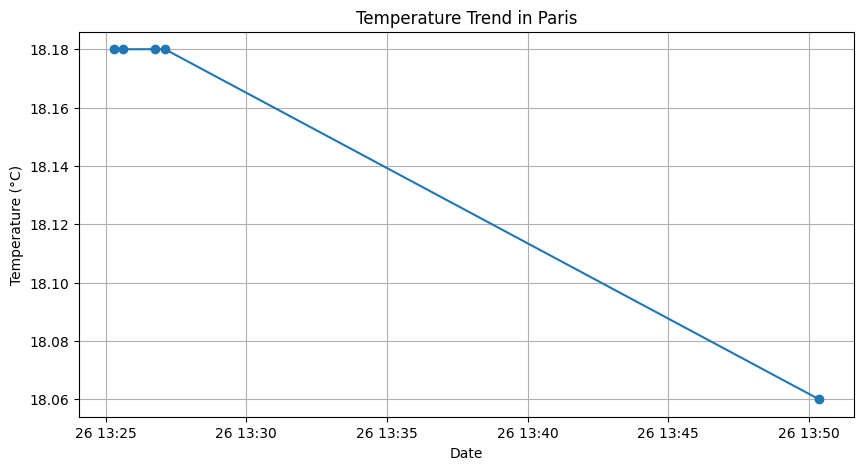

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

conn = psycopg2.connect(
    dbname='weather_db',
    user='postgres',
    password='testpass',
    host='localhost',
    port='5432'
)
df = pd.read_sql("SELECT * FROM weather WHERE city = 'Paris' ORDER BY date", conn)
plt.figure(figsize=(10,5))
plt.plot(df['date'], df['temperature_c'], marker='o')
plt.title('Temperature Trend in Paris')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid()
plt.show()
conn.close()


## Step 9: Visualizing Daily Trends

Previously, our trend analysis was based on both date and time, making the visualization less meaningful for daily trends.  
To better understand how many weather data entries we have per day, we group the data by date only (ignoring the time component).  
This allows us to plot the number of entries for each day and observe the daily trend more clearly.


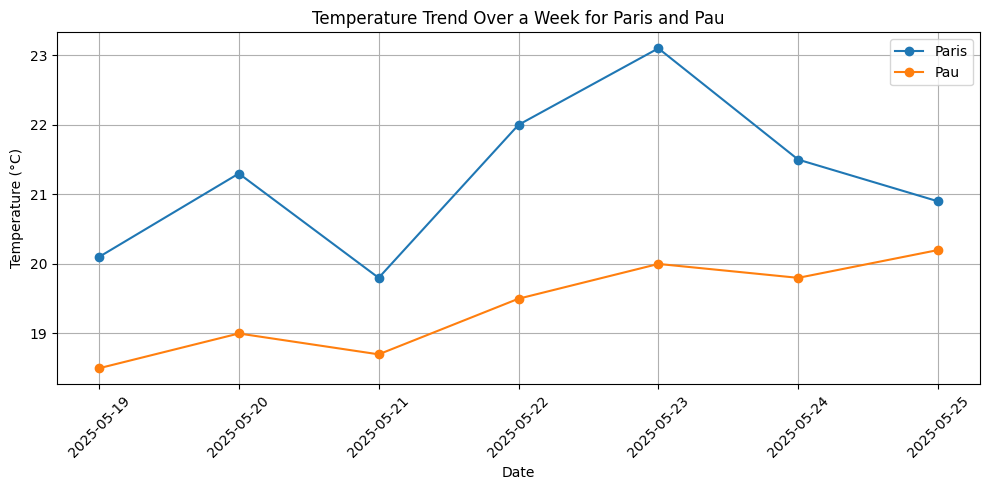

In [57]:
import matplotlib.pyplot as plt

weather_df['date_only'] = weather_df['date'].dt.date.astype(str)
pivot_df = weather_df.pivot(index='date_only', columns='city', values='temperature_c')

plt.figure(figsize=(10, 5))
for city in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[city], marker='o', label=city)

plt.title('Temperature Trend Over a Week for Paris and Pau')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## Why I Chose This Visualization

I chose this line chart to compare the temperature trends in Paris and Pau over a week because it provides a clear and intuitive way to observe how temperatures evolve in both cities day by day.

By plotting both cities on the same graph, I can easily identify similarities and differences in their weather patterns. The use of lines helps highlight changes and trends over time, making it simple to spot peaks, drops, or consistent periods in temperature for each city.

This visualization is especially useful for comparing multiple locations, as it allows me to see at a glance how the weather in Paris and Pau fluctuates together or diverges. It also makes it easier to communicate these insights to others, as the trends are visually distinct and easy to interpret.

Overall, this approach supports my goal of analyzing and comparing weather dynamics between different cities in a straightforward and visually engaging way.
